In [10]:
from tensorflow.keras.utils import load_img, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf

from sklearn.svm import OneClassSVM
from glob import glob
import pandas as pd
import numpy as np

In [2]:
mobilenetv2 = MobileNetV2(include_top=False, weights='imagenet')
# encoder = tf.keras.layers.Conv2D(1, kernel_size=3, padding="same")(mobilenetv2.layers[-1].output)

2023-02-05 17:22:01.104328: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-05 17:22:01.104352: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-05 17:22:01.104368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2023-02-05 17:22:01.104613: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# fnames = glob('images_001/images/*.png')
# len(fnames)

In [6]:
# images = np.stack([np.array(load_img(fname)) for fname in fnames[:100]])
images = image_dataset_from_directory(
    directory='images_007/',
    labels=None,
    shuffle=False,
    interpolation='bicubic')

Found 10000 files belonging to 1 classes.


In [7]:
X = mobilenetv2.predict(images)

313/313 [==============================] - 140s 445ms/step


In [8]:
X_max = np.max(X, axis=3)
X_max_flat = X_max.reshape(X_max.shape[0], X_max.shape[1]*X_max.shape[2])

In [9]:
X_mean = np.mean(X, axis=3)
X_mean_flat = X_mean.reshape(X_mean.shape[0], X_mean.shape[1]*X_mean.shape[2])

Train a one-class SVM and see if I can tune the parameters to get a more coherent result.

In [72]:
clf = OneClassSVM(nu=0.01, kernel='poly', degree=5)
clf.fit(X_mean_flat)

OneClassSVM(degree=5, kernel='poly', nu=0.01)

In [73]:
y_pred = clf.predict(X_mean_flat)

In [74]:
df = pd.DataFrame({
    'fname':images.file_paths,
    'y_pred':y_pred
})
df.head()

,fname,y_pred
0,images_007/images/00013774_026.png,1
1,images_007/images/00013774_027.png,1
2,images_007/images/00013774_028.png,1
3,images_007/images/00013774_029.png,1
4,images_007/images/00013774_030.png,1


In [75]:
df['y_pred'].value_counts()

 1    9901
-1      99
Name: y_pred, dtype: int64

In [84]:
df[df['y_pred']==-1].sample(5)

,fname,y_pred
530,images_007/images/00013909_000.png,-1
8688,images_007/images/00015718_000.png,-1
4790,images_007/images/00014759_002.png,-1
5732,images_007/images/00014998_000.png,-1
757,images_007/images/00013951_006.png,-1


In [77]:
df[df['y_pred']==1].sample(5)

,fname,y_pred
2861,images_007/images/00014332_000.png,1
1860,images_007/images/00014128_028.png,1
6060,images_007/images/00015064_000.png,1
2709,images_007/images/00014299_005.png,1
2547,images_007/images/00014264_006.png,1


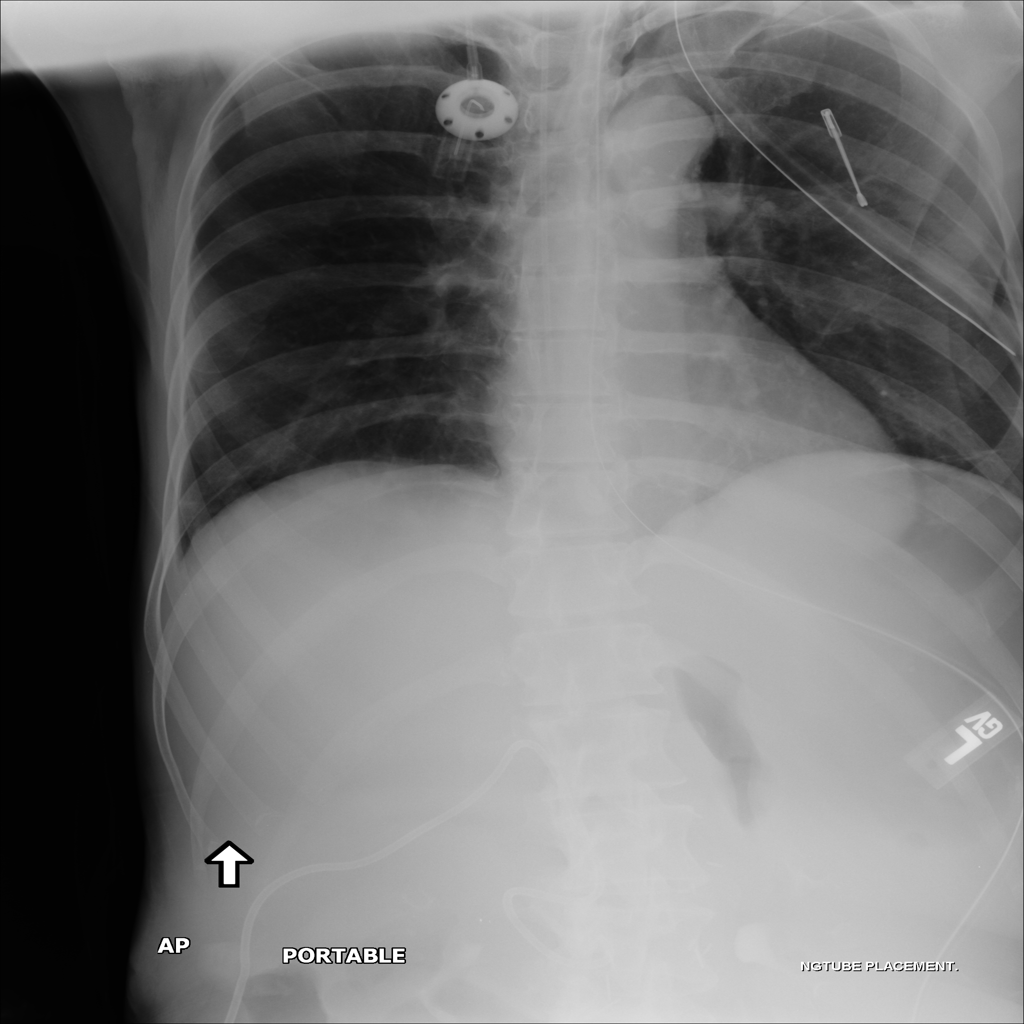

In [87]:
load_img(images.file_paths[4790])